In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
import optuna

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import warnings
import subprocess

%matplotlib inline

In [2]:
plt.style.use('ggplot')

warnings.filterwarnings('ignore')

In [3]:
def is_cuda_available():
    try:
        subprocess.check_output('nvidia-smi')
        return True
    except:
        return False

In [4]:
device = 'gpu' if is_cuda_available() else 'cpu'

print(f'Available device is {device}')

Available device is cpu


## 1. Data exploration

In [5]:
train_df = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [6]:
print(f'Train df shape is: {train_df.shape}.')
print(f'Train df memory usage is: {(train_df.memory_usage().sum() / 1024**2): .2f} MB.')
print(f'Test df shape is: {test_df.shape}.')
print(f'Test df memory usage is: {(test_df.memory_usage().sum() / 1024**2): .2f} MB.')

Train df shape is: (165034, 14).
Train df memory usage is:  17.63 MB.
Test df shape is: (110023, 13).
Test df memory usage is:  10.91 MB.


In [7]:
train_df.columns

Index(['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [8]:
df = pd.concat([train_df, test_df], axis=0)

In [9]:
print(f'Concatenated dataframe shape is: {df.shape}')

Concatenated dataframe shape is: (275057, 14)


In [10]:
unique_surnames = df.shape[0] - df['Surname'].duplicated().sum()

print(f'Number of unique surnames: {unique_surnames}.')

Number of unique surnames: 2889.


In [11]:
cols_to_drop = ['id', 'CustomerId', 'Surname']

df = df.drop(cols_to_drop, axis=1)

In [12]:
df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,668,France,Male,33.0,3,0.0,2,1.0,0.0,181449.97,0.0
1,627,France,Male,33.0,1,0.0,2,1.0,1.0,49503.50,0.0
2,678,France,Male,40.0,10,0.0,2,1.0,0.0,184866.69,0.0


In [13]:
df.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,275057.000000,275057.000000,275057.000000,275057.000000,275057.000000,275057.000000,275057.000000,275057.000000,165034.000000
mean,656.484939,38.124415,5.010867,55420.296450,1.554002,0.753589,0.496755,112470.952558,0.211599
std,80.188100,8.864927,2.806173,62805.933171,0.546178,0.430921,0.499990,50286.608747,0.408443
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74580.800000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117848.090000,0.000000
75%,710.000000,42.000000,7.000000,120037.960000,2.000000,1.000000,1.000000,154871.130000,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275057 entries, 0 to 110022
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CreditScore      275057 non-null  int64  
 1   Geography        275057 non-null  object 
 2   Gender           275057 non-null  object 
 3   Age              275057 non-null  float64
 4   Tenure           275057 non-null  int64  
 5   Balance          275057 non-null  float64
 6   NumOfProducts    275057 non-null  int64  
 7   HasCrCard        275057 non-null  float64
 8   IsActiveMember   275057 non-null  float64
 9   EstimatedSalary  275057 non-null  float64
 10  Exited           165034 non-null  float64
dtypes: float64(6), int64(3), object(2)
memory usage: 25.2+ MB


In [15]:
df.isna().sum()

CreditScore             0
Geography               0
Gender                  0
Age                     0
Tenure                  0
Balance                 0
NumOfProducts           0
HasCrCard               0
IsActiveMember          0
EstimatedSalary         0
Exited             110023
dtype: int64

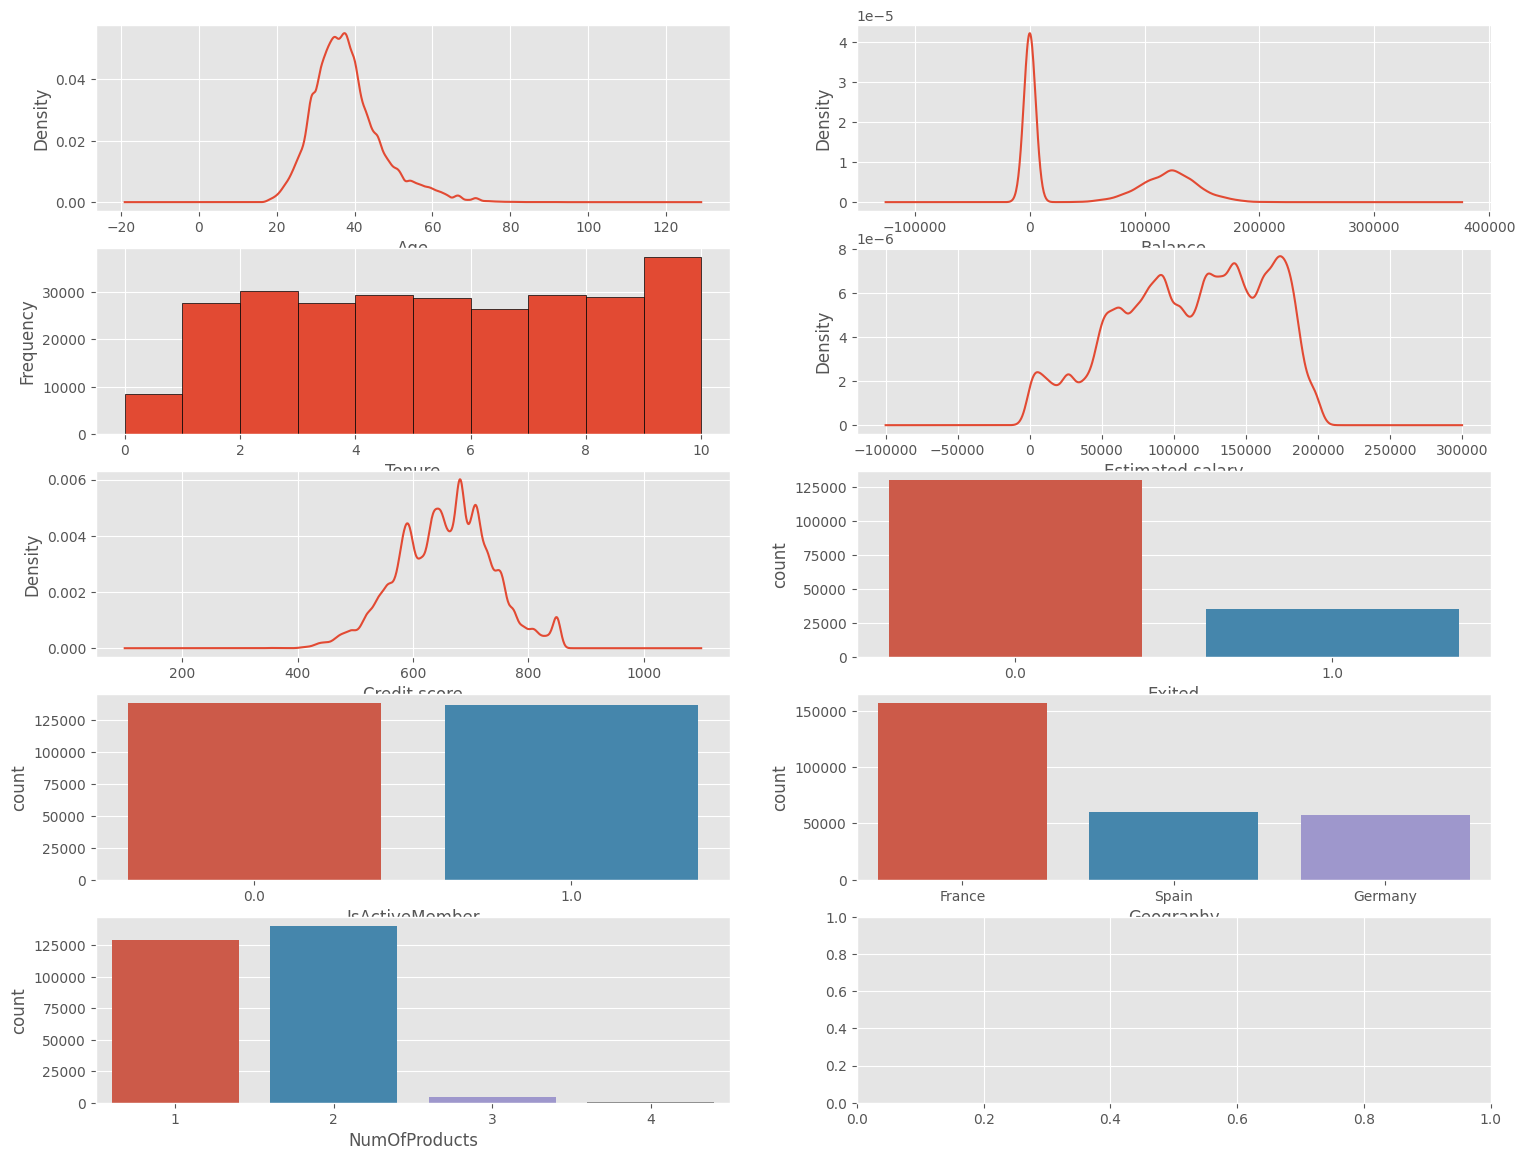

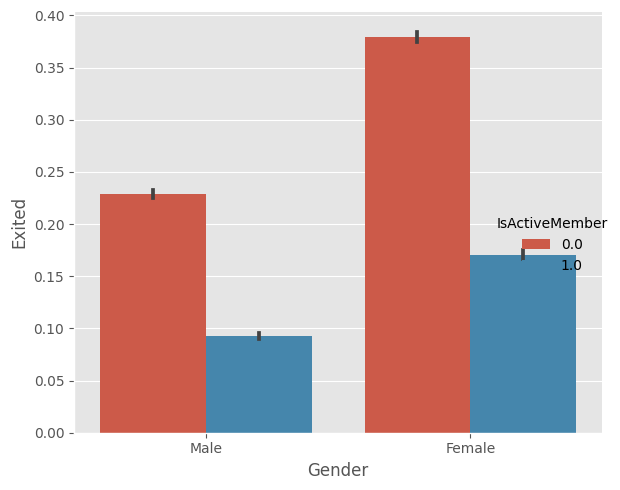

In [16]:
plt.figure(figsize=(18, 14))
plt.subplot(5, 2, 1)
df['Age'].plot(kind='kde')
plt.xlabel("Age")

plt.subplot(5, 2, 2)
df['Balance'].plot(kind='kde')
plt.xlabel('Balance')

plt.subplot(5, 2, 3)
df['Tenure'].plot(kind='hist', edgecolor='black', bins=10)
plt.xlabel('Tenure')

plt.subplot(5, 2, 4)
df['EstimatedSalary'].plot(kind='kde')
plt.xlabel('Estimated salary')

plt.subplot(5, 2, 5)
df['CreditScore'].plot(kind='kde')
plt.xlabel('Credit score')

plt.subplot(5, 2, 6)
sns.countplot(x=df['Exited'])

plt.subplot(5, 2, 7)
sns.countplot(x=df['IsActiveMember'])

plt.subplot(5, 2, 8)
sns.countplot(x=df['Geography'])

plt.subplot(5, 2, 9)
sns.countplot(x=df['NumOfProducts'])

plt.subplot(5, 2, 10)
sns.catplot(data=df, x='Gender', y='Exited', hue='IsActiveMember',kind='bar')

plt.tight_layout()
plt.show()

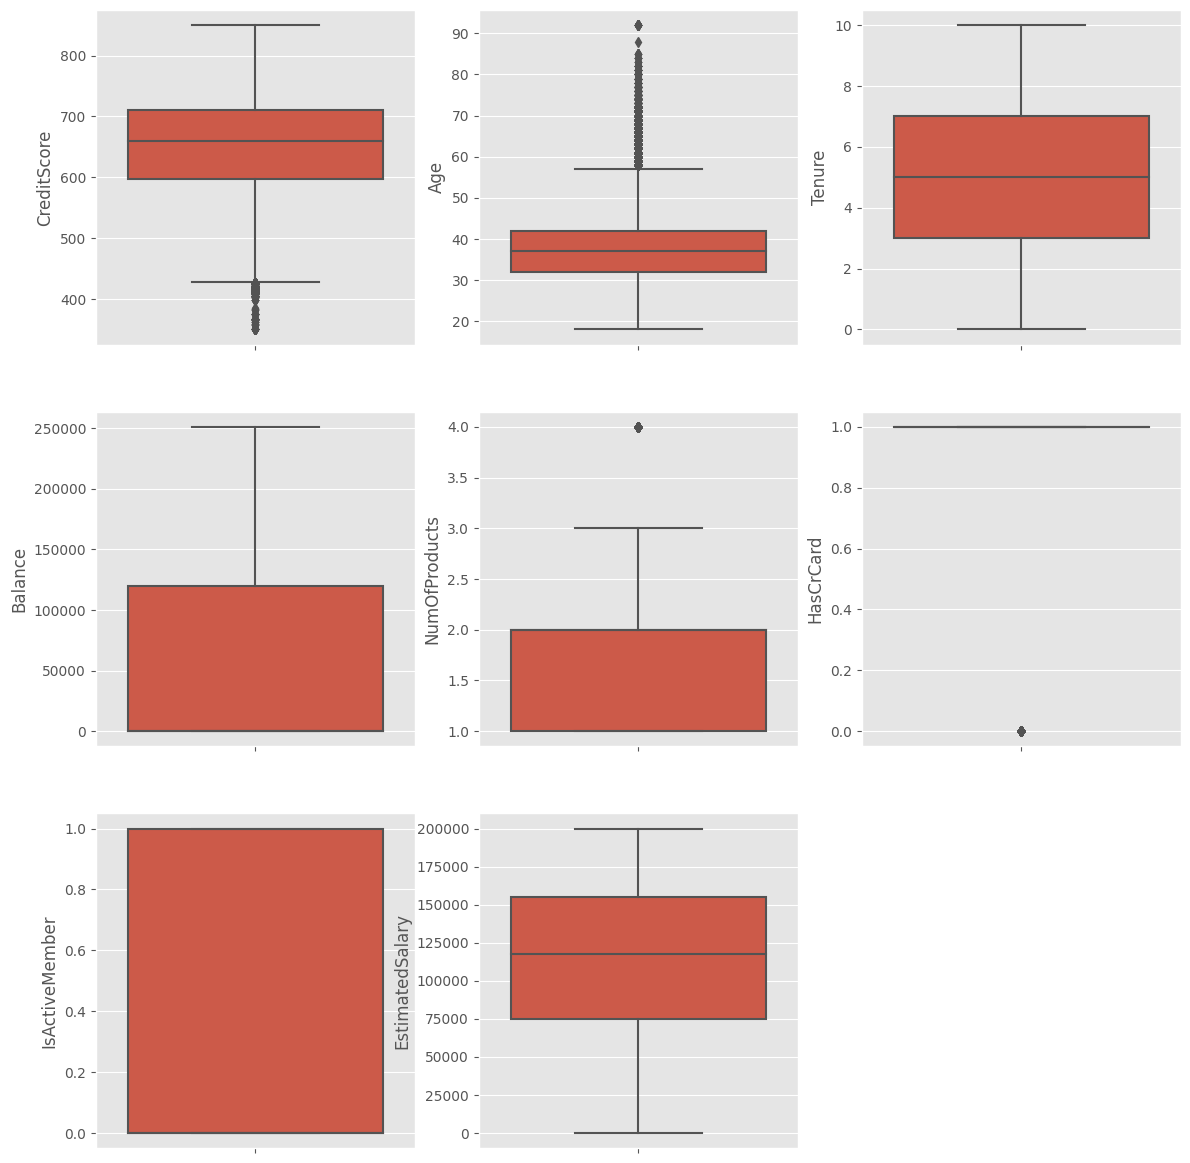

<Figure size 640x480 with 0 Axes>

In [17]:
cols = df.select_dtypes(exclude='object').columns
plt.figure(figsize=(14, 20))
for col in range(1, len(cols)):
    plt.subplot(4, 3, col)
    sns.boxplot(data=df, y=cols[col-1])

plt.show()
plt.tight_layout()

## 2. Data preprocessing

In [18]:
# df['IsSenior'] = df['Age'].apply(lambda x: 1 if x >= 65 else 0)
df['Active_by_CreditCard'] = df['HasCrCard'] * df['IsActiveMember']
df['Products_Per_Tenure'] =  df['Tenure'] / df['NumOfProducts']
df['AgeCat'] = np.round(df.Age/20).astype('int').astype('int8')

In [19]:
train_df['Sur_Geo_Gend_Sal'] = train_df['CustomerId'].astype('str')+train_df['Surname']+train_df['Geography']+train_df['Gender']+np.round(train_df.EstimatedSalary).astype('str')
test_df['Sur_Geo_Gend_Sal'] = train_df['CustomerId'].astype('str')+test_df['Surname']+test_df['Geography']+test_df['Gender']+np.round(test_df.EstimatedSalary).astype('str')

In [20]:
def get_vectors(df_train,df_test,col_name):
    vectorizer = TfidfVectorizer(max_features=1000)
    vectors_train = vectorizer.fit_transform(df_train[col_name])
    vectors_test = vectorizer.transform(df_test[col_name])
    
    svd = TruncatedSVD(3)
    x_pca_train = svd.fit_transform(vectors_train)
    x_pca_test = svd.transform(vectors_test)

    # Convert to DataFrames
    tfidf_df_train = pd.DataFrame(x_pca_train)
    tfidf_df_test = pd.DataFrame(x_pca_test)

    # Naming columns in the new DataFrames
    cols = [(col_name + "_tfidf_" + str(f)) for f in tfidf_df_train.columns.to_list()]
    tfidf_df_train.columns = cols
    tfidf_df_test.columns = cols

    # Reset the index of the DataFrames before concatenation
    df_train = df_train.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)

    # Concatenate transformed features with original data
    df_train = pd.concat([df_train, tfidf_df_train], axis="columns")
    df_test = pd.concat([df_test, tfidf_df_test], axis="columns")
    return df_train,df_test

In [21]:
train_df,test_df = get_vectors(train_df,test_df,'Surname')
train_df,test_df = get_vectors(train_df,test_df,'Sur_Geo_Gend_Sal')

In [22]:
train_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,Sur_Geo_Gend_Sal,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,Sur_Geo_Gend_Sal_tfidf_1,Sur_Geo_Gend_Sal_tfidf_2
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,...,0.0,181449.97,0,15674932OkwudilichukwuFranceMale181450.0,1.110856e-08,-1.290589e-06,5.693328e-07,0.0,0.0,0.0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,...,1.0,49503.50,0,15749177OkwudiliolisaFranceMale49504.0,-4.461613e-07,3.529330e-06,-3.070346e-06,0.0,0.0,0.0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,...,0.0,184866.69,0,15694510HsuehFranceMale184867.0,-4.151403e-04,-1.553548e-03,7.758118e-04,0.0,0.0,0.0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,...,1.0,84560.88,0,15741417KaoFranceMale84561.0,-1.184817e-05,-1.116365e-04,-5.965268e-05,0.0,0.0,0.0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,...,1.0,15068.83,0,15766172ChiemenamSpainMale15069.0,1.132390e-07,1.910625e-07,-1.445638e-06,0.0,0.0,0.0


In [23]:
train_df.drop(['id', 'CustomerId', 'Surname', 'Sur_Geo_Gend_Sal'], axis=1, inplace=True)
test_df.drop(['id', 'CustomerId', 'Surname', 'Sur_Geo_Gend_Sal'], axis=1, inplace=True)

In [24]:
cols_to_dummies = ['NumOfProducts', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
preprocessor = ColumnTransformer(transformers=[('enc', OneHotEncoder(handle_unknown='ignore'), cols_to_dummies)])

transformed_data = preprocessor.fit_transform(test_df)

feature_names = ( preprocessor.named_transformers_['enc']
                 .get_feature_names_out(cols_to_dummies).tolist())

transformed_df = pd.DataFrame(transformed_data, columns=feature_names, index=test_df.index)

test_df = pd.concat([test_df, transformed_df], axis=1)



preprocessor = ColumnTransformer(transformers=[('enc', OneHotEncoder(handle_unknown='ignore'), cols_to_dummies)])

transformed_data = preprocessor.fit_transform(train_df)

feature_names = ( preprocessor.named_transformers_['enc']
                 .get_feature_names_out(cols_to_dummies).tolist())

transformed_df = pd.DataFrame(transformed_data, columns=feature_names, index=train_df.index)

train_df = pd.concat([train_df, transformed_df], axis=1)

In [25]:
train_df.drop(['NumOfProducts', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], axis=1, inplace=True)
test_df.drop(['NumOfProducts', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember'], axis=1, inplace=True)

In [26]:
scl = MinMaxScaler()

In [27]:
for col in ['CreditScore', 'Age', 'EstimatedSalary', 'Balance', 'Tenure']:
    test_df[col] = scl.fit_transform(test_df[[col]])
    
train_df.describe()

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Surname_tfidf_0,Surname_tfidf_1,Surname_tfidf_2,Sur_Geo_Gend_Sal_tfidf_0,...,NumOfProducts_4,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0
count,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,1.650340e+05,165034.000000,1.650340e+05,165034.000000,...,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,656.454373,38.125888,5.020353,55478.086689,112574.822734,0.211599,3.092067e-02,0.014874,-9.082471e-03,0.000188,...,0.002878,0.570882,0.209690,0.219428,0.435571,0.564429,0.246046,0.753954,0.502230,0.497770
std,80.103340,8.867205,2.806159,62817.663278,50292.865585,0.408443,1.356759e-01,0.121075,1.210222e-01,0.013371,...,0.053572,0.494952,0.407089,0.413860,0.495833,0.495833,0.430707,0.430707,0.499997,0.499997
min,350.000000,18.000000,0.000000,0.000000,11.580000,0.000000,-1.909988e-03,-0.005509,-6.256016e-01,-0.026680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,597.000000,32.000000,3.000000,0.000000,74637.570000,0.000000,-9.271820e-08,-0.000002,-2.367027e-05,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,659.000000,37.000000,5.000000,0.000000,117948.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000
75%,710.000000,42.000000,7.000000,119939.517500,155152.467500,0.000000,3.179673e-06,0.000003,5.250593e-07,0.000000,...,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000
max,850.000000,92.000000,10.000000,250898.090000,199992.480000,1.000000,9.444231e-01,0.999900,6.392213e-01,0.985470,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [28]:
X_train = train_df.drop('Exited', axis=1)
y_train = train_df['Exited']

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, shuffle=True)

## 3. Model

In [30]:
models = {
    'Catboost' : CatBoostClassifier(random_state=42, verbose=0, task_type=device.upper()),
    'RF' : RandomForestClassifier(random_state=42),
    'LR' : LogisticRegression(random_state=42),
    'XGB' : XGBClassifier(random_state=42, device=device),
    'LGBM' : LGBMClassifier(random_state=42, device=device)
}

for model_name, model in models.items():
    score = cross_val_score(model, X=X_val, y=y_val, cv=5, n_jobs=-1, scoring='roc_auc').mean()
    print(f'{model_name} : {score}')

Catboost : 0.8900596809920783
RF : 0.8752504460705858
LR : 0.7146516791240468
XGB : 0.881712428393446
[LightGBM] [Info] Number of positive: 6897, number of negative: 26110
[LightGBM] [Info] Number of positive: 6897, number of negative: 26110
[LightGBM] [Info] Number of positive: 6897, number of negative: 26110
[LightGBM] [Info] Number of positive: 6896, number of negative: 26111
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2362
[LightGBM] [Info] Number of data points in the train set: 33007, number of used features: 24
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2360
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhea

In [31]:
def XGBobjective(trial):
    params = {
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "random_state" : 42,
        "device" : device
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    auc = roc_auc_score(y_val, predictions)
    return auc

In [32]:
study = optuna.create_study(direction='maximize')
study.optimize(XGBobjective, n_trials=30)

[I 2025-03-30 17:14:50,919] A new study created in memory with name: no-name-4e578bf7-d390-44a1-b760-0712d8f6e7f8
[I 2025-03-30 17:15:04,406] Trial 0 finished with value: 0.7561033908545577 and parameters: {'learning_rate': 0.01438453213784772, 'max_depth': 9, 'subsample': 0.23907967810145825, 'colsample_bytree': 0.5231988422831477, 'min_child_weight': 2}. Best is trial 0 with value: 0.7561033908545577.
[I 2025-03-30 17:15:08,076] Trial 1 finished with value: 0.7333123082757451 and parameters: {'learning_rate': 0.021590296963088652, 'max_depth': 1, 'subsample': 0.4867791870023375, 'colsample_bytree': 0.34782978534048725, 'min_child_weight': 6}. Best is trial 0 with value: 0.7561033908545577.
[I 2025-03-30 17:15:16,549] Trial 2 finished with value: 0.7496414766607468 and parameters: {'learning_rate': 0.00936635879726625, 'max_depth': 6, 'subsample': 0.31290718327943345, 'colsample_bytree': 0.3415760698568032, 'min_child_weight': 11}. Best is trial 0 with value: 0.7561033908545577.
[I 20

In [33]:
study.best_params

{'learning_rate': 0.06534527649883098,
 'max_depth': 6,
 'subsample': 0.8934523421120332,
 'colsample_bytree': 0.8391512937297039,
 'min_child_weight': 20}

In [34]:
params = {
        'n_estimators' : 1000,
        'verbosity' : 0,
        'learning_rate' : 0.010911178827075277,
        'max_depth' : 5,
        'subsample' : 0.6559018249638597,
        'colsample_bytree' : 0.9218406935933311,
        'min_child_weight': 12,
        'random_state' : 42,
        'device' : device}

In [35]:
xgbc = XGBClassifier(**params)

In [36]:
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9218406935933311, device='cpu',
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010911178827075277,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=12, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
def LGBMCobjective(trial):
    params = {
        "n_estimators": 1000,
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "random_state" : 42,
        "device" : device
    }
    
    model = LGBMClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    auc = roc_auc_score(y_val, predictions)
    return auc

In [38]:
study = optuna.create_study(direction='maximize')
study.optimize(LGBMCobjective, n_trials=30)

[I 2025-03-30 17:19:28,002] A new study created in memory with name: no-name-5e73aac6-d27a-4460-88cf-89684794e483
[I 2025-03-30 17:21:19,553] Trial 0 finished with value: 0.7230519875314761 and parameters: {'learning_rate': 0.007219525298080916, 'num_leaves': 697, 'subsample': 0.7519439013634349, 'colsample_bytree': 0.23561469083695818, 'min_data_in_leaf': 68}. Best is trial 0 with value: 0.7230519875314761.
[I 2025-03-30 17:22:26,983] Trial 1 finished with value: 0.7527723830056586 and parameters: {'learning_rate': 0.008407526083546965, 'num_leaves': 680, 'subsample': 0.8612972803889698, 'colsample_bytree': 0.8083559934551119, 'min_data_in_leaf': 41}. Best is trial 1 with value: 0.7527723830056586.
[I 2025-03-30 17:23:17,602] Trial 2 finished with value: 0.7372516349323184 and parameters: {'learning_rate': 0.0035059652909857322, 'num_leaves': 460, 'subsample': 0.6696322457322493, 'colsample_bytree': 0.4604183409265987, 'min_data_in_leaf': 80}. Best is trial 1 with value: 0.75277238300

In [39]:
study.best_params

{'learning_rate': 0.06164306555193584,
 'num_leaves': 21,
 'subsample': 0.9961569922926734,
 'colsample_bytree': 0.547269619176043,
 'min_data_in_leaf': 30}

In [40]:
params = {
        'n_estimators' : 1000,
        'verbosity' : -1,
        'bagging_freq' : 1,
        'learning_rate': 0.0748855039519162,
        'num_leaves': 13,
        'subsample': 0.9757548304246405,
        'colsample_bytree': 0.9927314493929604,
        'min_data_in_leaf': 95,
        'random_state' : 42,
        'device' : device
    }

In [41]:
lgbm = LGBMClassifier(**params)

In [42]:
lgbm.fit(X_train, y_train)

LGBMClassifier(bagging_freq=1, colsample_bytree=0.9927314493929604,
               device='cpu', learning_rate=0.0748855039519162,
               min_data_in_leaf=95, n_estimators=1000, num_leaves=13,
               random_state=42, subsample=0.9757548304246405, verbosity=-1)

In [43]:
def CatBoostObjective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'eval_metric' : 'AUC',
        'random_state' : 42,
        'task_type' : 'CPU',
        'verbose' : 0
    }

    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    predictions = model.predict(X_val)
    auc = roc_auc_score(y_val, predictions)
    return auc

In [44]:
study = optuna.create_study(direction='maximize')
study.optimize(CatBoostObjective, n_trials=30)

[I 2025-03-30 17:41:43,773] A new study created in memory with name: no-name-20bc772e-500d-418d-af72-104ea842c39b
[I 2025-03-30 17:42:33,752] Trial 0 finished with value: 0.7503276443111838 and parameters: {'learning_rate': 0.011174926592194467, 'depth': 10, 'colsample_bylevel': 0.7234566292892262, 'min_data_in_leaf': 54}. Best is trial 0 with value: 0.7503276443111838.
[I 2025-03-30 17:43:04,843] Trial 1 finished with value: 0.7516594318959686 and parameters: {'learning_rate': 0.02686924139130013, 'depth': 10, 'colsample_bylevel': 0.1524667980809855, 'min_data_in_leaf': 56}. Best is trial 1 with value: 0.7516594318959686.
[I 2025-03-30 17:43:15,270] Trial 2 finished with value: 0.6779764840163776 and parameters: {'learning_rate': 0.004343933444936616, 'depth': 1, 'colsample_bylevel': 0.35202193095384054, 'min_data_in_leaf': 86}. Best is trial 1 with value: 0.7516594318959686.
[I 2025-03-30 17:43:43,856] Trial 3 finished with value: 0.738740067346668 and parameters: {'learning_rate': 0

In [45]:
params = {
        'iterations' : 1000,
        'learning_rate': 0.04419219678459441,
        'depth': 6,
        'colsample_bylevel': 0.599192483339213,
        'min_data_in_leaf': 19,
        'eval_metric' : 'AUC',
        'random_state' : 42,
        'task_type' : 'CPU',
        'verbose' : 0}

In [46]:
catboost = CatBoostClassifier(**params)

In [47]:
catboost.fit(X_train, y_train)

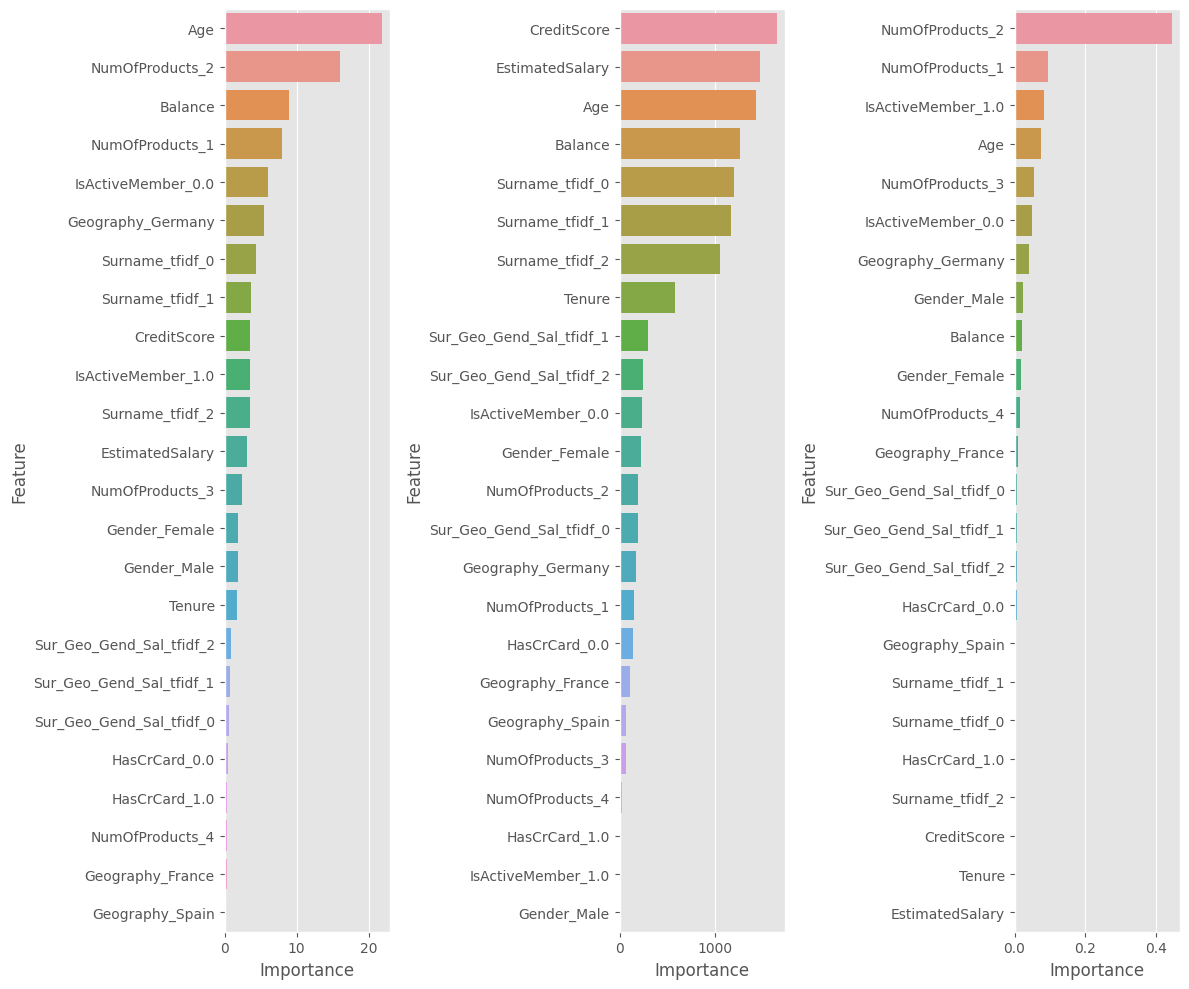

In [48]:
plt.figure(figsize=(12, 10))

feature_importances = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : catboost.feature_importances_})
plt.subplot(1, 3, 1)
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False), x='Importance', y='Feature')

feature_importances = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : lgbm.feature_importances_})
plt.subplot(1, 3, 2)
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False), x='Importance', y='Feature')

feature_importances = pd.DataFrame({'Feature' : X_train.columns, 'Importance' : xgbc.feature_importances_})
plt.subplot(1, 3, 3)
sns.barplot(data=feature_importances.sort_values(by='Importance', ascending=False), x='Importance', y='Feature')

plt.tight_layout()
plt.show()

In [49]:
y_preds = lgbm.predict(X_val)

<Axes: >

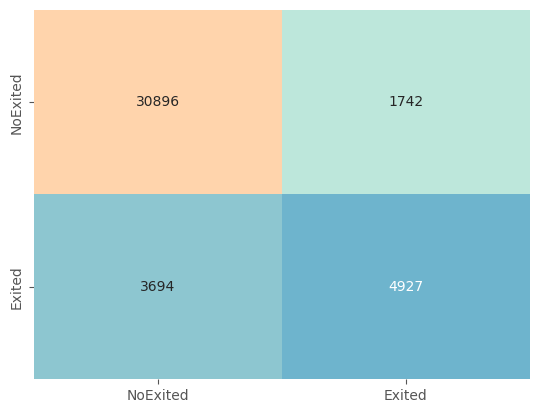

In [50]:
cm = confusion_matrix(y_val, y_preds)

sns.heatmap(cm, annot=True, fmt='d', cbar=False,
            cmap='icefire',
            xticklabels=['NoExited', 'Exited'], 
            yticklabels=['NoExited', 'Exited'])

In [51]:
metrics = {
    'F1' : f1_score(y_val, y_preds),
    'Acc' : accuracy_score(y_val, y_preds),
    'Recall' : recall_score(y_val, y_preds),
    'Precision' : precision_score(y_val, y_preds),
    'AUC' : roc_auc_score(y_val, y_preds)
}

In [52]:
for metric, score in metrics.items():
    print(f'{metric} : {score}')

F1 : 0.6444735120994115
Acc : 0.8682469279429943
Recall : 0.5715114255886788
Precision : 0.7387914230019493
AUC : 0.7590690285612369


In [53]:
fpr, tpr, treshold = roc_curve(y_val, y_preds)

In [54]:
auc = roc_auc_score(y_val, y_preds)

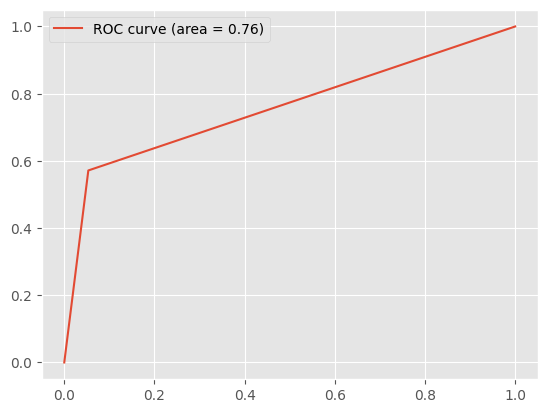

In [55]:
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
plt.legend()

In [56]:
voting_cls = VotingClassifier([('lgbm', lgbm), ('catboost', catboost), ('xgbc', xgbc)], voting='soft').fit(X_train, y_train)

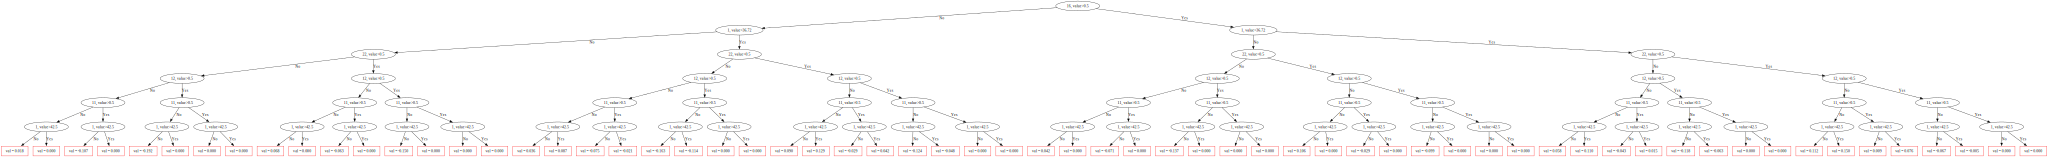

In [57]:
catboost.plot_tree(tree_idx=0)

<Axes: >

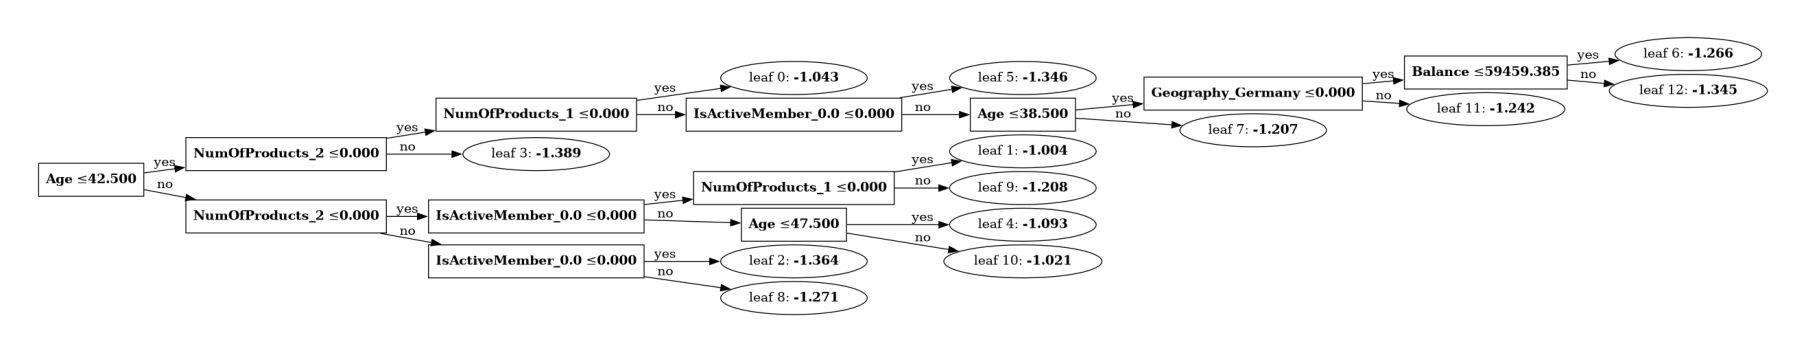

In [58]:
lgb.plot_tree(lgbm, tree_index=0, dpi=350)

In [59]:
preds = voting_cls.predict_proba(test_df)[:, 1]

In [60]:
s_df = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv')

In [61]:
submission = pd.DataFrame({'id' : s_df['id'], 'Exited' : preds})

In [62]:
submission.to_csv('submission.csv', index=False)